In [1]:
from math import *
import matplotlib.pyplot as plt
from scipy.integrate import ode
import time
import matplotlib.pyplot as plt
import gym
import torch as th
import os
from datetime import datetime
import csv
import numpy as np

from stable_baselines3 import TD3, SAC
from stable_baselines3.common.callbacks import BaseCallback, EvalCallback
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.results_plotter import load_results, ts2xy, plot_results
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import SubprocVecEnv, VecMonitor
from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv

from bipedalWalkerPMTG import BipedalWalkerPMTG

/home/yoggi/biped_research/env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Whether to use gpu or cpu

In [ ]:
use_gpu = True

In [2]:
# Addresses
env_name = "BipedalWalker-v3"
model_saved_file = "./models/bipedWalkerHardcore_PMTG_SAC"
log_dir = "./models/PMTG_SAC-bipedalWalkerHardcore-model"
best_model_dir = "./models/PMTG_SAC-bipedalWalkerHardcore-model/best_single"
video_prefix = "bipedWalkerHardcore_PMTG_SAC"
csv_addr = "./statistics/bipedWalkerHardcore2d_PMTG_SAC_rewards.csv"
time_addr = "./statistics/bipedWalkerHardcore2d_PMTG_SAC_elapcedTime.txt"
csv_path = "./statistics/bipedWalkerHardcore2d_PMTG_SAC_rewards.csv"
time_path = "./statistics/bipedWalkerHardcore2d_PMTG_SAC_elapcedTime.txt"
tb_log = "./PMTGHardcore_tensorboard/"
tb_log_name = "PMTG_SAC_exp1"
best_video_prefix = "bipedWalkerHardcore_PMTG_SAC"

# Training Parameters
if use_gpu == True:
    device = "cuda"
else:
    device = "cpu"
    num_cpu = 1

is_hard = True
n_timesteps = int(1e7)

seed = 2
check_freq = 1000
reward_threshold = 300

# Hyperparameters
learning_rate = 7.3e-4
batch_size = 256
gamma = 0.99 #
tau = 0.01
buffer_size = 2000000
learning_starts = 10000
noise_std = 0.1
gradient_steps = 1
ent_coef = 0.005
train_freq = 1
n_layers = 2
n_neurons = 256

activation = th.nn.modules.activation.ReLU
net_arch = [400, 300]
policy_kwargs = dict(activation_fn=activation, 
                    net_arch=net_arch)

hyperparameters = {
        #"env_name": env_name,
        "n_timesteps": n_timesteps,
        "seed": seed,
        "noise_std": noise_std,

        "batch_size": batch_size,
        "buffer_size": buffer_size,
        "tau": tau,
        "learning_starts": learning_starts,
        "gradient_steps": gradient_steps,
        "gamma": gamma,
        "ent_coef": ent_coef,
        "learning_rate": learning_rate,
        "train_freq": train_freq,
        "policy_kwargs": dict(
            net_arch=net_arch,
            activation_fn=activation,
        ),
    }

# other params
it = 0
os.makedirs(log_dir, exist_ok=True)

Create environments

In [3]:
env = BipedalWalkerPMTG(is_hard=True, action_repeat=3, act_noise=0.3, rew_scale=5.0, learn=True)
env = Monitor(env, log_dir)
eval_env = BipedalWalkerPMTG(is_hard=True, action_repeat=1, act_noise=0.0, rew_scale=1.0, learn=False)
 
obs = env.reset()

Create the model

In [5]:
model = SAC(policy='MlpPolicy', 
        env=env,
        # action_noise=action_noise,
        train_freq=train_freq,

        learning_rate=learning_rate,
        batch_size=batch_size,
        tau=tau,
        gamma=gamma,
        buffer_size=buffer_size,
        learning_starts=learning_starts,
        gradient_steps=gradient_steps,
        ent_coef=ent_coef,

        policy_kwargs=policy_kwargs,

        device=device,
        seed=seed,
        verbose=0,
        tensorboard_log=tb_log)

In [7]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq:
    :param log_dir: Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: Verbosity level.
    """
    def __init__(self, check_freq: int, log_dir: str, verbose: int = 1):
        super(SaveOnBestTrainingRewardCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, 'best_model')
        self.best_mean_reward = -np.inf
        self.mean_reward_lst = []
        self.timesteps = []
        self.s_reward = []
        self.s_timestep = []
        self.file_number = 0

    def _init_callback(self) -> None:
        pass

    def _on_step(self) -> bool:
        if self.num_timesteps % self.check_freq == 0:

          # Retrieve training reward
          x, y = ts2xy(load_results(self.log_dir), 'timesteps')
          
          if len(x) > 0:
            # Mean training reward over the last 100 episodes
            mean_reward = np.mean(y[-100:])
            self.mean_reward_lst.append(mean_reward)
            self.timesteps.append(self.num_timesteps)
            episodes = len(y)

            self.s_reward.append(mean_reward)
            self.s_timestep.append(self.num_timesteps)

            if self.verbose > 0:
              print(f"Num timesteps: {self.num_timesteps}; Episodes: {episodes}")
              print(f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}")

            # New best model, you could save the agent here
            if mean_reward > self.best_mean_reward:
              self.best_mean_reward = mean_reward
              print(f"Saving new best model to {self.save_path}...")
              self.model.save(self.save_path)

            # 300-scores candidate test
            if mean_reward > reward_threshold*4.2:
              Yellow = "\033[0;33m"
              NC = "\033[0m"
              print("{0}Reward threshold achieved{1}".format(Yellow, NC))
              print("Evaluating model....")
              evals= evaluate_policy(model, eval_env, n_eval_episodes=100, deterministic=True, render=False, callback=None,
                              reward_threshold=None)
              mean_reward_100 = np.mean(evals[0])
              std_reward = np.mean(evals[1])
              print(f"Evaluation over 100 Episodes: {mean_reward_100} ")

              if mean_reward_100 >= reward_threshold:
                # create folder for best models
                now = datetime.now()
                dt_string = now.strftime("%Y-%m-%d_%H-%M-%S")
                best_dir = "{0}/{1}".format(best_model_dir, dt_string)
                os.makedirs(best_dir, exist_ok=True)
                # save model file
                self.model.save(best_dir)
                print(f"Saving new best model to {self.save_path}...")
                # save file with hyperparameters, episodes number and reward
                print("Saving training info...")
                filename = "{0}/training_info.txt".format(best_dir)
                print(filename)
                with open(filename, mode="w") as f:
                    f.write("Episodes: {0}\r\n".format(episodes))
                    f.write("Timesteps: {0}\r\n".format(self.num_timesteps))
                    f.write("Eval reward: {0}\r\n".format(mean_reward_100))
                    f.write("Info and Hyperparameters:\r\n")
                    for k, v in hyperparameters.items():
                        str = "    {0}: {1}\r\n".format(k, v)
                        f.write(str)
                # save reward curve
                print("Saving reward CSV-data...")
                filename = "{0}/rewards.csv".format(best_dir)
                with open(filename, mode='w') as reward_file:
                    reward_writer = csv.writer(reward_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)

                    for i in range(len(self.s_timestep)):
                        reward_writer.writerow([self.s_reward[i], self.s_timestep[i]])
                print(f"MISSION COMPLETED")
                print(f"Score: {mean_reward_100}+/-{std_reward} reached at Episode: {episodes} ")
                return False
        if self.num_timesteps % 10000 == 0:
          print("Saving new model file...")
          self.file_number += 1
          filename = "model{0}".format(self.file_number)
          nsave_path = os.path.join(log_dir, filename)
          self.model.save(nsave_path)
          

        return True

    def get_mean_reward(self):
      return self.mean_reward_lst, self.timesteps

_XSERVTransSocketUNIXCreateListener: ...SocketCreateListener() failed
_XSERVTransMakeAllCOTSServerListeners: server already running
(EE) 
Fatal server error:
(EE) Cannot establish any listening sockets - Make sure an X server isn't already running(EE) 


In [8]:
callback = SaveOnBestTrainingRewardCallback(check_freq=check_freq, log_dir=log_dir)

In [9]:
model.learn(n_timesteps, tb_log_name=tb_log_name, callback=callback)

Num timesteps: 1000; Episodes: 50
Best mean reward: -inf - Last mean reward per episode: -46.33
Saving new best model to ./models/PMTG_SAC-bipedalWalkerHardcore-model/best_model...
Num timesteps: 2000; Episodes: 97
Best mean reward: -46.33 - Last mean reward per episode: -48.79
Num timesteps: 3000; Episodes: 141
Best mean reward: -46.33 - Last mean reward per episode: -50.33
Num timesteps: 4000; Episodes: 183
Best mean reward: -46.33 - Last mean reward per episode: -50.09
Num timesteps: 5000; Episodes: 228
Best mean reward: -46.33 - Last mean reward per episode: -51.13
Num timesteps: 6000; Episodes: 280
Best mean reward: -46.33 - Last mean reward per episode: -50.76
Num timesteps: 7000; Episodes: 325
Best mean reward: -46.33 - Last mean reward per episode: -54.11
Num timesteps: 8000; Episodes: 376
Best mean reward: -46.33 - Last mean reward per episode: -53.73
Num timesteps: 9000; Episodes: 424
Best mean reward: -46.33 - Last mean reward per episode: -46.77
Num timesteps: 10000; Episod

/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 247.02777256922482 
Num timesteps: 1385000; Episodes: 6041
Best mean reward: 1260.67 - Last mean reward per episode: 1259.89
Num timesteps: 1386000; Episodes: 6045
Best mean reward: 1260.67 - Last mean reward per episode: 1245.06
Num timesteps: 1387000; Episodes: 6047
Best mean reward: 1260.67 - Last mean reward per episode: 1241.56
Num timesteps: 1388000; Episodes: 6049
Best mean reward: 1260.67 - Last mean reward per episode: 1240.95
Num timesteps: 1389000; Episodes: 6052
Best mean reward: 1260.67 - Last mean reward per episode: 1242.79
Num timesteps: 1390000; Episodes: 6054
Best mean reward: 1260.67 - Last mean reward per episode: 1246.52
Saving new model file...
Num timesteps: 1391000; Episodes: 6057
Best mean reward: 1260.67 - Last mean reward per episode: 1229.43
Num timesteps: 1392000; Episodes: 6061
Best mean reward: 1260.67 - Last mean reward per episode: 1207.52
Num timesteps: 1393000; Episodes: 6063
Best mean reward: 1260.67 - Last mean reward p

/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 231.294653155509 
Num timesteps: 1493000; Episodes: 6327
Best mean reward: 1267.72 - Last mean reward per episode: 1268.23
Saving new best model to ./models/PMTG_SAC-bipedalWalkerHardcore-model/best_model...
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 224.49350297682864 
Num timesteps: 1494000; Episodes: 6329
Best mean reward: 1268.23 - Last mean reward per episode: 1268.46
Saving new best model to ./models/PMTG_SAC-bipedalWalkerHardcore-model/best_model...
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 295.9896881470213 
Num timesteps: 1495000; Episodes: 6332
Best mean reward: 1268.46 - Last mean reward per episode: 1264.81
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 280.84218561926986 
Num timesteps: 1496000; Episodes: 6334
Best mean reward: 1268.46 - Last mean reward per episode: 1261.89
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 256.03948786620373 
Num timesteps: 1497000; Episodes: 6336
Best mean reward: 1268.46 - Last mean reward per episode: 1259.93
Num timesteps: 1498000; Episodes: 6338
Best mean reward: 1268.46 - Last mean reward per episode: 1264.57
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 294.2874055545136 
Num timesteps: 1499000; Episodes: 6340
Best mean reward: 1268.46 - Last mean reward per episode: 1276.49
Saving new best model to ./models/PMTG_SAC-bipedalWalkerHardcore-model/best_model...
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 297.89452982351287 
Num timesteps: 1500000; Episodes: 6343
Best mean reward: 1276.49 - Last mean reward per episode: 1284.98
Saving new best model to ./models/PMTG_SAC-bipedalWalkerHardcore-model/best_model...
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 205.58654535925854 
Saving new model file...
Num timesteps: 1501000; Episodes: 6346
Best mean reward: 1284.98 - Last mean reward per episode: 1284.26
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 148.19859960782625 
Num timesteps: 1502000; Episodes: 6348
Best mean reward: 1284.98 - Last mean reward per episode: 1287.30
Saving new best model to ./models/PMTG_SAC-bipedalWalkerHardcore-model/best_model...
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 293.0745484660908 
Num timesteps: 1503000; Episodes: 6351
Best mean reward: 1287.30 - Last mean reward per episode: 1277.80
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 294.84128521206947 
Num timesteps: 1504000; Episodes: 6354
Best mean reward: 1287.30 - Last mean reward per episode: 1271.27
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 247.48385924271733 
Num timesteps: 1505000; Episodes: 6356
Best mean reward: 1287.30 - Last mean reward per episode: 1271.53
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 238.5742995598887 
Num timesteps: 1506000; Episodes: 6359
Best mean reward: 1287.30 - Last mean reward per episode: 1273.12
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 262.52154496844656 
Num timesteps: 1507000; Episodes: 6361
Best mean reward: 1287.30 - Last mean reward per episode: 1280.72
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 261.0426194396228 
Num timesteps: 1508000; Episodes: 6363
Best mean reward: 1287.30 - Last mean reward per episode: 1280.26
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 204.94320541739984 
Num timesteps: 1509000; Episodes: 6366
Best mean reward: 1287.30 - Last mean reward per episode: 1276.74
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 284.8669071163918 
Num timesteps: 1510000; Episodes: 6369
Best mean reward: 1287.30 - Last mean reward per episode: 1280.20
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 295.5725090928045 
Saving new model file...
Num timesteps: 1511000; Episodes: 6373
Best mean reward: 1287.30 - Last mean reward per episode: 1273.42
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 193.9319590141301 
Num timesteps: 1512000; Episodes: 6375
Best mean reward: 1287.30 - Last mean reward per episode: 1273.75
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 287.8219640524465 
Num timesteps: 1513000; Episodes: 6377
Best mean reward: 1287.30 - Last mean reward per episode: 1273.25
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 193.37861997421342 
Num timesteps: 1514000; Episodes: 6380
Best mean reward: 1287.30 - Last mean reward per episode: 1264.55
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 296.0851150777149 
Num timesteps: 1515000; Episodes: 6383
Best mean reward: 1287.30 - Last mean reward per episode: 1276.98
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 269.23843350662673 
Num timesteps: 1516000; Episodes: 6385
Best mean reward: 1287.30 - Last mean reward per episode: 1279.57
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 276.4597551355995 
Num timesteps: 1517000; Episodes: 6387
Best mean reward: 1287.30 - Last mean reward per episode: 1278.83
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 273.53493453997925 
Num timesteps: 1518000; Episodes: 6389
Best mean reward: 1287.30 - Last mean reward per episode: 1286.00
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 207.18158670727175 
Num timesteps: 1519000; Episodes: 6392
Best mean reward: 1287.30 - Last mean reward per episode: 1296.47
Saving new best model to ./models/PMTG_SAC-bipedalWalkerHardcore-model/best_model...
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 280.7601590238957 
Num timesteps: 1520000; Episodes: 6395
Best mean reward: 1296.47 - Last mean reward per episode: 1289.07
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 272.60020410392883 
Saving new model file...
Num timesteps: 1521000; Episodes: 6397
Best mean reward: 1296.47 - Last mean reward per episode: 1288.74
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 278.9154173772672 
Num timesteps: 1522000; Episodes: 6399
Best mean reward: 1296.47 - Last mean reward per episode: 1297.09
Saving new best model to ./models/PMTG_SAC-bipedalWalkerHardcore-model/best_model...
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 236.786311666263 
Num timesteps: 1523000; Episodes: 6402
Best mean reward: 1297.09 - Last mean reward per episode: 1301.77
Saving new best model to ./models/PMTG_SAC-bipedalWalkerHardcore-model/best_model...
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 288.03225407789716 
Num timesteps: 1524000; Episodes: 6405
Best mean reward: 1301.77 - Last mean reward per episode: 1298.17
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 289.4393811151387 
Num timesteps: 1525000; Episodes: 6409
Best mean reward: 1301.77 - Last mean reward per episode: 1275.28
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 278.9683561292644 
Num timesteps: 1526000; Episodes: 6412
Best mean reward: 1301.77 - Last mean reward per episode: 1273.30
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 231.77982089168108 
Num timesteps: 1527000; Episodes: 6414
Best mean reward: 1301.77 - Last mean reward per episode: 1272.57
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 274.3823726722218 
Num timesteps: 1528000; Episodes: 6417
Best mean reward: 1301.77 - Last mean reward per episode: 1276.26
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 206.77694257730798 
Num timesteps: 1529000; Episodes: 6419
Best mean reward: 1301.77 - Last mean reward per episode: 1275.43
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 259.2280086739658 
Num timesteps: 1530000; Episodes: 6422
Best mean reward: 1301.77 - Last mean reward per episode: 1273.15
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 161.32689601391087 
Saving new model file...
Num timesteps: 1531000; Episodes: 6424
Best mean reward: 1301.77 - Last mean reward per episode: 1272.84
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 229.22062876526914 
Num timesteps: 1532000; Episodes: 6427
Best mean reward: 1301.77 - Last mean reward per episode: 1268.54
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 189.71765057046989 
Num timesteps: 1533000; Episodes: 6429
Best mean reward: 1301.77 - Last mean reward per episode: 1258.69
Num timesteps: 1534000; Episodes: 6432
Best mean reward: 1301.77 - Last mean reward per episode: 1262.70
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 147.6576892333211 
Num timesteps: 1535000; Episodes: 6435
Best mean reward: 1301.77 - Last mean reward per episode: 1258.20
Num timesteps: 1536000; Episodes: 6438
Best mean reward: 1301.77 - Last mean reward per episode: 1250.60
Num timesteps: 1537000; Episodes: 6440
Best mean reward: 1301.77 - Last mean reward per episode: 1249.71
Num timesteps: 1538000; Episodes: 6443
Best mean reward: 1301.77 - Last mean reward per episode: 1243.45
Num timesteps: 1539000; Episodes: 6445
Best mean reward: 1301.77 - Last mean reward per episode: 1252.82
Num timesteps: 1540000; Episodes: 6447
Best mean reward: 1301.77 - Last mean reward per episode: 1258.74
Saving new model file...
Num timesteps: 1541000; Episodes: 6450
Best mean reward: 1301.77 - Last mean reward per episode: 1268.45
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 280.388174334019 
Num timesteps: 1542000; Episodes: 6452
Best mean reward: 1301.77 - Last mean reward per episode: 1269.72
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 282.7281944866061 
Num timesteps: 1543000; Episodes: 6454
Best mean reward: 1301.77 - Last mean reward per episode: 1279.45
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 265.7234691615436 
Num timesteps: 1544000; Episodes: 6456
Best mean reward: 1301.77 - Last mean reward per episode: 1278.72
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 291.62902289430605 
Num timesteps: 1545000; Episodes: 6460
Best mean reward: 1301.77 - Last mean reward per episode: 1261.11
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 229.0053953560338 
Num timesteps: 1546000; Episodes: 6462
Best mean reward: 1301.77 - Last mean reward per episode: 1263.77
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 226.45404863815762 
Num timesteps: 1547000; Episodes: 6465
Best mean reward: 1301.77 - Last mean reward per episode: 1260.13
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 189.26232862451806 
Num timesteps: 1548000; Episodes: 6468
Best mean reward: 1301.77 - Last mean reward per episode: 1273.02
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 171.90361083875564 
Num timesteps: 1549000; Episodes: 6470
Best mean reward: 1301.77 - Last mean reward per episode: 1273.31
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 290.2844560290193 
Num timesteps: 1550000; Episodes: 6474
Best mean reward: 1301.77 - Last mean reward per episode: 1267.17
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 287.22358308893405 
Saving new model file...
Num timesteps: 1551000; Episodes: 6478
Best mean reward: 1301.77 - Last mean reward per episode: 1235.60
Num timesteps: 1552000; Episodes: 6481
Best mean reward: 1301.77 - Last mean reward per episode: 1239.96
Num timesteps: 1553000; Episodes: 6483
Best mean reward: 1301.77 - Last mean reward per episode: 1239.55
Num timesteps: 1554000; Episodes: 6486
Best mean reward: 1301.77 - Last mean reward per episode: 1229.83
Num timesteps: 1555000; Episodes: 6489
Best mean reward: 1301.77 - Last mean reward per episode: 1219.23
Num timesteps: 1556000; Episodes: 6491
Best mean reward: 1301.77 - Last mean reward per episode: 1219.14
Num timesteps: 1557000; Episodes: 6493
Best mean reward: 1301.77 - Last mean reward per episode: 1227.23
Num timesteps: 1558000; Episodes: 6496
Best mean reward: 1301.77 - Last mean reward per episode: 1214.66
Num timesteps: 1559000; Episodes: 6499
Best mean reward: 1301.77 - Last mean reward p

/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 269.9661774200441 
Num timesteps: 1640000; Episodes: 6711
Best mean reward: 1301.77 - Last mean reward per episode: 1273.69
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 150.78839215629134 
Saving new model file...
Num timesteps: 1641000; Episodes: 6713
Best mean reward: 1301.77 - Last mean reward per episode: 1272.71
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 260.08129600120685 
Num timesteps: 1642000; Episodes: 6716
Best mean reward: 1301.77 - Last mean reward per episode: 1266.64
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 191.4143668965902 
Num timesteps: 1643000; Episodes: 6719
Best mean reward: 1301.77 - Last mean reward per episode: 1264.48
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 223.77724622274144 
Num timesteps: 1644000; Episodes: 6721
Best mean reward: 1301.77 - Last mean reward per episode: 1263.95
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 184.61133040806 
Num timesteps: 1645000; Episodes: 6723
Best mean reward: 1301.77 - Last mean reward per episode: 1264.59
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 267.17574698068967 
Num timesteps: 1646000; Episodes: 6726
Best mean reward: 1301.77 - Last mean reward per episode: 1274.96
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 285.80902223427904 
Num timesteps: 1647000; Episodes: 6728
Best mean reward: 1301.77 - Last mean reward per episode: 1288.24
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 260.89585667505867 
Num timesteps: 1648000; Episodes: 6730
Best mean reward: 1301.77 - Last mean reward per episode: 1288.57
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 268.2072763113593 
Num timesteps: 1649000; Episodes: 6733
Best mean reward: 1301.77 - Last mean reward per episode: 1291.73
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 260.6335081331929 
Num timesteps: 1650000; Episodes: 6735
Best mean reward: 1301.77 - Last mean reward per episode: 1291.92
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 245.74187769809876 
Saving new model file...
Num timesteps: 1651000; Episodes: 6737
Best mean reward: 1301.77 - Last mean reward per episode: 1302.33
Saving new best model to ./models/PMTG_SAC-bipedalWalkerHardcore-model/best_model...
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 252.51922933321723 
Num timesteps: 1652000; Episodes: 6740
Best mean reward: 1302.33 - Last mean reward per episode: 1304.23
Saving new best model to ./models/PMTG_SAC-bipedalWalkerHardcore-model/best_model...
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 284.0943188743378 
Num timesteps: 1653000; Episodes: 6743
Best mean reward: 1304.23 - Last mean reward per episode: 1302.02
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 260.92817501679883 
Num timesteps: 1654000; Episodes: 6746
Best mean reward: 1304.23 - Last mean reward per episode: 1288.20
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 285.1873563480383 
Num timesteps: 1655000; Episodes: 6749
Best mean reward: 1304.23 - Last mean reward per episode: 1288.51
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 288.48070060425044 
Num timesteps: 1656000; Episodes: 6751
Best mean reward: 1304.23 - Last mean reward per episode: 1276.91
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 269.7974824794161 
Num timesteps: 1657000; Episodes: 6754
Best mean reward: 1304.23 - Last mean reward per episode: 1266.49
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 292.9644878179504 
Num timesteps: 1658000; Episodes: 6757
Best mean reward: 1304.23 - Last mean reward per episode: 1267.10
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 286.21675582126335 
Num timesteps: 1659000; Episodes: 6759
Best mean reward: 1304.23 - Last mean reward per episode: 1270.75
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 299.4416688651708 
Num timesteps: 1660000; Episodes: 6761
Best mean reward: 1304.23 - Last mean reward per episode: 1283.26
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 282.279440244287 
Saving new model file...
Num timesteps: 1661000; Episodes: 6764
Best mean reward: 1304.23 - Last mean reward per episode: 1285.90
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 182.2008001936798 
Num timesteps: 1662000; Episodes: 6767
Best mean reward: 1304.23 - Last mean reward per episode: 1286.66
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 109.78240578204763 
Num timesteps: 1663000; Episodes: 6769
Best mean reward: 1304.23 - Last mean reward per episode: 1287.09
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 249.77802022881176 
Num timesteps: 1664000; Episodes: 6772
Best mean reward: 1304.23 - Last mean reward per episode: 1300.75
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 264.125894511917 
Num timesteps: 1665000; Episodes: 6774
Best mean reward: 1304.23 - Last mean reward per episode: 1292.30
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 256.7529602481278 
Num timesteps: 1666000; Episodes: 6777
Best mean reward: 1304.23 - Last mean reward per episode: 1292.69
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 260.29359856753507 
Num timesteps: 1667000; Episodes: 6779
Best mean reward: 1304.23 - Last mean reward per episode: 1292.22
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 291.03138706277 
Num timesteps: 1668000; Episodes: 6782
Best mean reward: 1304.23 - Last mean reward per episode: 1292.27
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 283.8657624428454 
Num timesteps: 1669000; Episodes: 6784
Best mean reward: 1304.23 - Last mean reward per episode: 1297.15
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 186.6438888872365 
Num timesteps: 1670000; Episodes: 6787
Best mean reward: 1304.23 - Last mean reward per episode: 1296.37
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 242.99724075127307 
Saving new model file...
Num timesteps: 1671000; Episodes: 6789
Best mean reward: 1304.23 - Last mean reward per episode: 1297.72
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 293.5010372729303 
Num timesteps: 1672000; Episodes: 6792
Best mean reward: 1304.23 - Last mean reward per episode: 1302.90
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 284.4734882684537 
Num timesteps: 1673000; Episodes: 6794
Best mean reward: 1304.23 - Last mean reward per episode: 1307.46
Saving new best model to ./models/PMTG_SAC-bipedalWalkerHardcore-model/best_model...
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 273.28049485972207 
Num timesteps: 1674000; Episodes: 6797
Best mean reward: 1307.46 - Last mean reward per episode: 1303.95
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 292.0843927821191 
Num timesteps: 1675000; Episodes: 6800
Best mean reward: 1307.46 - Last mean reward per episode: 1303.93
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 224.4842712020387 
Num timesteps: 1676000; Episodes: 6802
Best mean reward: 1307.46 - Last mean reward per episode: 1305.36
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 290.41374195995695 
Num timesteps: 1677000; Episodes: 6805
Best mean reward: 1307.46 - Last mean reward per episode: 1305.53
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 270.27637219915016 
Num timesteps: 1678000; Episodes: 6807
Best mean reward: 1307.46 - Last mean reward per episode: 1311.23
Saving new best model to ./models/PMTG_SAC-bipedalWalkerHardcore-model/best_model...
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 254.92028462057692 
Num timesteps: 1679000; Episodes: 6809
Best mean reward: 1311.23 - Last mean reward per episode: 1311.35
Saving new best model to ./models/PMTG_SAC-bipedalWalkerHardcore-model/best_model...
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 147.35925467613018 
Num timesteps: 1680000; Episodes: 6812
Best mean reward: 1311.35 - Last mean reward per episode: 1311.85
Saving new best model to ./models/PMTG_SAC-bipedalWalkerHardcore-model/best_model...
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 187.90413983326718 
Saving new model file...
Num timesteps: 1681000; Episodes: 6815
Best mean reward: 1311.85 - Last mean reward per episode: 1310.30
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 228.24971184035837 
Num timesteps: 1682000; Episodes: 6817
Best mean reward: 1311.85 - Last mean reward per episode: 1314.51
Saving new best model to ./models/PMTG_SAC-bipedalWalkerHardcore-model/best_model...
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 296.1086715531871 
Num timesteps: 1683000; Episodes: 6819
Best mean reward: 1314.51 - Last mean reward per episode: 1320.68
Saving new best model to ./models/PMTG_SAC-bipedalWalkerHardcore-model/best_model...
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 223.65251132149584 
Num timesteps: 1684000; Episodes: 6822
Best mean reward: 1320.68 - Last mean reward per episode: 1320.60
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 143.7152994896688 
Num timesteps: 1685000; Episodes: 6824
Best mean reward: 1320.68 - Last mean reward per episode: 1320.78
Saving new best model to ./models/PMTG_SAC-bipedalWalkerHardcore-model/best_model...
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 278.5587496535389 
Num timesteps: 1686000; Episodes: 6827
Best mean reward: 1320.78 - Last mean reward per episode: 1319.74
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 152.72027195433094 
Num timesteps: 1687000; Episodes: 6829
Best mean reward: 1320.78 - Last mean reward per episode: 1319.49
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 274.60954970068497 
Num timesteps: 1688000; Episodes: 6831
Best mean reward: 1320.78 - Last mean reward per episode: 1319.32
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 173.68688920919232 
Num timesteps: 1689000; Episodes: 6834
Best mean reward: 1320.78 - Last mean reward per episode: 1319.03
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 243.524095245778 
Num timesteps: 1690000; Episodes: 6836
Best mean reward: 1320.78 - Last mean reward per episode: 1318.77
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 287.5921967087046 
Saving new model file...
Num timesteps: 1691000; Episodes: 6838
Best mean reward: 1320.78 - Last mean reward per episode: 1318.12
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 231.10791499084 
Num timesteps: 1692000; Episodes: 6841
Best mean reward: 1320.78 - Last mean reward per episode: 1324.47
Saving new best model to ./models/PMTG_SAC-bipedalWalkerHardcore-model/best_model...
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 270.44318141140116 
Num timesteps: 1693000; Episodes: 6844
Best mean reward: 1324.47 - Last mean reward per episode: 1318.76
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 253.78747798910163 
Num timesteps: 1694000; Episodes: 6847
Best mean reward: 1324.47 - Last mean reward per episode: 1325.81
Saving new best model to ./models/PMTG_SAC-bipedalWalkerHardcore-model/best_model...
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 295.41393444655273 
Num timesteps: 1695000; Episodes: 6849
Best mean reward: 1325.81 - Last mean reward per episode: 1325.65
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 298.9601053126737 
Num timesteps: 1696000; Episodes: 6851
Best mean reward: 1325.81 - Last mean reward per episode: 1337.00
Saving new best model to ./models/PMTG_SAC-bipedalWalkerHardcore-model/best_model...
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 290.5147631350797 
Num timesteps: 1697000; Episodes: 6854
Best mean reward: 1337.00 - Last mean reward per episode: 1345.31
Saving new best model to ./models/PMTG_SAC-bipedalWalkerHardcore-model/best_model...
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 290.621037629096 
Num timesteps: 1698000; Episodes: 6857
Best mean reward: 1345.31 - Last mean reward per episode: 1335.04
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 294.580470121233 
Num timesteps: 1699000; Episodes: 6859
Best mean reward: 1345.31 - Last mean reward per episode: 1335.08
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 293.5181013216247 
Num timesteps: 1700000; Episodes: 6862
Best mean reward: 1345.31 - Last mean reward per episode: 1335.70
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 262.52703242073375 
Saving new model file...
Num timesteps: 1701000; Episodes: 6864
Best mean reward: 1345.31 - Last mean reward per episode: 1341.52
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 168.10835885616666 
Num timesteps: 1702000; Episodes: 6867
Best mean reward: 1345.31 - Last mean reward per episode: 1343.82
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 282.6675815968423 
Num timesteps: 1703000; Episodes: 6870
Best mean reward: 1345.31 - Last mean reward per episode: 1330.25
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 270.7622617472713 
Num timesteps: 1704000; Episodes: 6872
Best mean reward: 1345.31 - Last mean reward per episode: 1331.54
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 296.8515215824991 
Num timesteps: 1705000; Episodes: 6875
Best mean reward: 1345.31 - Last mean reward per episode: 1332.79
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 287.2226610737587 
Num timesteps: 1706000; Episodes: 6877
Best mean reward: 1345.31 - Last mean reward per episode: 1332.29
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 241.30128212116873 
Num timesteps: 1707000; Episodes: 6880
Best mean reward: 1345.31 - Last mean reward per episode: 1332.45
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 193.09828333426506 
Num timesteps: 1708000; Episodes: 6882
Best mean reward: 1345.31 - Last mean reward per episode: 1336.71
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 290.7577278184353 
Num timesteps: 1709000; Episodes: 6885
Best mean reward: 1345.31 - Last mean reward per episode: 1334.68
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 150.843621341725 
Num timesteps: 1710000; Episodes: 6887
Best mean reward: 1345.31 - Last mean reward per episode: 1335.32
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 287.7985778556317 
Saving new model file...
Num timesteps: 1711000; Episodes: 6889
Best mean reward: 1345.31 - Last mean reward per episode: 1335.40
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 279.9680652599448 
Num timesteps: 1712000; Episodes: 6893
Best mean reward: 1345.31 - Last mean reward per episode: 1330.64
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 285.4664880148772 
Num timesteps: 1713000; Episodes: 6896
Best mean reward: 1345.31 - Last mean reward per episode: 1322.38
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 270.78563748488284 
Num timesteps: 1714000; Episodes: 6899
Best mean reward: 1345.31 - Last mean reward per episode: 1315.84
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 280.8215678331656 
Num timesteps: 1715000; Episodes: 6902
Best mean reward: 1345.31 - Last mean reward per episode: 1303.67
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 291.6436941350155 
Num timesteps: 1716000; Episodes: 6904
Best mean reward: 1345.31 - Last mean reward per episode: 1303.35
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 220.8047439527815 
Num timesteps: 1717000; Episodes: 6907
Best mean reward: 1345.31 - Last mean reward per episode: 1303.16
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 222.33077971105212 
Num timesteps: 1718000; Episodes: 6910
Best mean reward: 1345.31 - Last mean reward per episode: 1289.22
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 154.71802473360802 
Num timesteps: 1719000; Episodes: 6912
Best mean reward: 1345.31 - Last mean reward per episode: 1285.41
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 214.61490521781693 
Num timesteps: 1720000; Episodes: 6915
Best mean reward: 1345.31 - Last mean reward per episode: 1293.94
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 263.65921210230204 
Saving new model file...
Num timesteps: 1721000; Episodes: 6917
Best mean reward: 1345.31 - Last mean reward per episode: 1294.41
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 296.53850590820815 
Num timesteps: 1722000; Episodes: 6920
Best mean reward: 1345.31 - Last mean reward per episode: 1281.54
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 290.42941939269326 
Num timesteps: 1723000; Episodes: 6924
Best mean reward: 1345.31 - Last mean reward per episode: 1267.77
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 237.38719904967965 
Num timesteps: 1724000; Episodes: 6927
Best mean reward: 1345.31 - Last mean reward per episode: 1258.70
Num timesteps: 1725000; Episodes: 6929
Best mean reward: 1345.31 - Last mean reward per episode: 1258.47
Num timesteps: 1726000; Episodes: 6931
Best mean reward: 1345.31 - Last mean reward per episode: 1259.09
Num timesteps: 1727000; Episodes: 6934
Best mean reward: 1345.31 - Last mean reward per episode: 1253.40
Num timesteps: 1728000; Episodes: 6938
Best mean reward: 1345.31 - Last mean reward per episode: 1241.10
Num timesteps: 1729000; Episodes: 6940
Best mean reward: 1345.31 - Last mean reward per episode: 1240.49
Num timesteps: 1730000; Episodes: 6943
Best mean reward: 1345.31 - Last mean reward per episode: 1253.09
Saving new model file...
Num timesteps: 1731000; Episodes: 6946
Best mean reward: 1345.31 - Last mean reward per episode: 1239.96
Num timesteps: 1732000; Episodes: 6949
Best mean reward: 1345.31 - Last mean reward p

/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 173.1278509647872 
Num timesteps: 1767000; Episodes: 7040
Best mean reward: 1345.31 - Last mean reward per episode: 1269.83
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 288.11079767550797 
Num timesteps: 1768000; Episodes: 7043
Best mean reward: 1345.31 - Last mean reward per episode: 1260.80
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 273.4741451644775 
Num timesteps: 1769000; Episodes: 7045
Best mean reward: 1345.31 - Last mean reward per episode: 1270.57
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 213.35340977644628 
Num timesteps: 1770000; Episodes: 7047
Best mean reward: 1345.31 - Last mean reward per episode: 1282.83
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 229.60762805231016 
Saving new model file...
Num timesteps: 1771000; Episodes: 7049
Best mean reward: 1345.31 - Last mean reward per episode: 1290.94
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 280.80873556272786 
Num timesteps: 1772000; Episodes: 7052
Best mean reward: 1345.31 - Last mean reward per episode: 1282.53
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 252.1575613592947 
Num timesteps: 1773000; Episodes: 7054
Best mean reward: 1345.31 - Last mean reward per episode: 1292.78
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 182.82230590684188 
Num timesteps: 1774000; Episodes: 7057
Best mean reward: 1345.31 - Last mean reward per episode: 1296.21
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 275.4801337576884 
Num timesteps: 1775000; Episodes: 7061
Best mean reward: 1345.31 - Last mean reward per episode: 1273.94
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 223.50355278313734 
Num timesteps: 1776000; Episodes: 7064
Best mean reward: 1345.31 - Last mean reward per episode: 1279.12
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 230.93886956018534 
Num timesteps: 1777000; Episodes: 7066
Best mean reward: 1345.31 - Last mean reward per episode: 1279.20
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 253.8215879437672 
Num timesteps: 1778000; Episodes: 7068
Best mean reward: 1345.31 - Last mean reward per episode: 1274.99
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 273.13723032128183 
Num timesteps: 1779000; Episodes: 7071
Best mean reward: 1345.31 - Last mean reward per episode: 1274.91
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 274.41093289819787 
Num timesteps: 1780000; Episodes: 7073
Best mean reward: 1345.31 - Last mean reward per episode: 1274.55
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 292.1094470505846 
Saving new model file...
Num timesteps: 1781000; Episodes: 7075
Best mean reward: 1345.31 - Last mean reward per episode: 1277.53
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 271.774822886673 
Num timesteps: 1782000; Episodes: 7079
Best mean reward: 1345.31 - Last mean reward per episode: 1279.13
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 282.2382444035406 
Num timesteps: 1783000; Episodes: 7081
Best mean reward: 1345.31 - Last mean reward per episode: 1278.86
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 242.0722960382887 
Num timesteps: 1784000; Episodes: 7084
Best mean reward: 1345.31 - Last mean reward per episode: 1278.42
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 203.40130768986302 
Num timesteps: 1785000; Episodes: 7086
Best mean reward: 1345.31 - Last mean reward per episode: 1288.23
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 290.1089665044256 
Num timesteps: 1786000; Episodes: 7088
Best mean reward: 1345.31 - Last mean reward per episode: 1283.87
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 246.42172286017995 
Num timesteps: 1787000; Episodes: 7091
Best mean reward: 1345.31 - Last mean reward per episode: 1290.82
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 282.5332125031948 
Num timesteps: 1788000; Episodes: 7094
Best mean reward: 1345.31 - Last mean reward per episode: 1290.22
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 290.19601121736616 
Num timesteps: 1789000; Episodes: 7096
Best mean reward: 1345.31 - Last mean reward per episode: 1291.23
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 289.12424432538137 
Num timesteps: 1790000; Episodes: 7099
Best mean reward: 1345.31 - Last mean reward per episode: 1299.68
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 282.80071253979725 
Saving new model file...
Num timesteps: 1791000; Episodes: 7101
Best mean reward: 1345.31 - Last mean reward per episode: 1293.01
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 289.4189469702588 
Num timesteps: 1792000; Episodes: 7104
Best mean reward: 1345.31 - Last mean reward per episode: 1293.83
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 267.0799352147416 
Num timesteps: 1793000; Episodes: 7108
Best mean reward: 1345.31 - Last mean reward per episode: 1269.98
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 210.99873312987893 
Num timesteps: 1794000; Episodes: 7111
Best mean reward: 1345.31 - Last mean reward per episode: 1279.60
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 246.95267682005505 
Num timesteps: 1795000; Episodes: 7113
Best mean reward: 1345.31 - Last mean reward per episode: 1279.28
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 268.1759488593475 
Num timesteps: 1796000; Episodes: 7116
Best mean reward: 1345.31 - Last mean reward per episode: 1275.85
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 294.3589348922509 
Num timesteps: 1797000; Episodes: 7118
Best mean reward: 1345.31 - Last mean reward per episode: 1275.87
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 198.54275673336943 
Num timesteps: 1798000; Episodes: 7121
Best mean reward: 1345.31 - Last mean reward per episode: 1275.47
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 158.1156100377292 
Num timesteps: 1799000; Episodes: 7124
Best mean reward: 1345.31 - Last mean reward per episode: 1265.17
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 298.0662392499582 
Num timesteps: 1800000; Episodes: 7126
Best mean reward: 1345.31 - Last mean reward per episode: 1264.88
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 278.1356282576609 
Saving new model file...
Num timesteps: 1801000; Episodes: 7129
Best mean reward: 1345.31 - Last mean reward per episode: 1260.96
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 231.04304482399894 
Num timesteps: 1802000; Episodes: 7131
Best mean reward: 1345.31 - Last mean reward per episode: 1261.07
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 276.2436186874765 
Num timesteps: 1803000; Episodes: 7135
Best mean reward: 1345.31 - Last mean reward per episode: 1245.37
Num timesteps: 1804000; Episodes: 7137
Best mean reward: 1345.31 - Last mean reward per episode: 1250.74
Num timesteps: 1805000; Episodes: 7140
Best mean reward: 1345.31 - Last mean reward per episode: 1245.16
Num timesteps: 1806000; Episodes: 7143
Best mean reward: 1345.31 - Last mean reward per episode: 1240.67
Num timesteps: 1807000; Episodes: 7145
Best mean reward: 1345.31 - Last mean reward per episode: 1241.38
Num timesteps: 1808000; Episodes: 7148
Best mean reward: 1345.31 - Last mean reward per episode: 1228.79
Num timesteps: 1809000; Episodes: 7151
Best mean reward: 1345.31 - Last mean reward per episode: 1231.04
Num timesteps: 1810000; Episodes: 7153
Best mean reward: 1345.31 - Last mean reward per episode: 1238.01
Saving new model file...
Num timesteps: 1811000; Episodes: 7156
Best mean reward: 1345.31 - Last mean reward pe

/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 296.9837898664558 
Num timesteps: 1838000; Episodes: 7227
Best mean reward: 1345.31 - Last mean reward per episode: 1263.82
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 271.1839819993653 
Num timesteps: 1839000; Episodes: 7230
Best mean reward: 1345.31 - Last mean reward per episode: 1257.66
Num timesteps: 1840000; Episodes: 7233
Best mean reward: 1345.31 - Last mean reward per episode: 1248.96
Saving new model file...
Num timesteps: 1841000; Episodes: 7237
Best mean reward: 1345.31 - Last mean reward per episode: 1242.95
Num timesteps: 1842000; Episodes: 7239
Best mean reward: 1345.31 - Last mean reward per episode: 1244.74
Num timesteps: 1843000; Episodes: 7241
Best mean reward: 1345.31 - Last mean reward per episode: 1256.15
Num timesteps: 1844000; Episodes: 7244
Best mean reward: 1345.31 - Last mean reward per episode: 1252.64
Num timesteps: 1845000; Episodes: 7246
Best mean reward: 1345.31 - Last mean reward per episode: 1250.09
Num timesteps: 1846000; Episodes: 7248
Best mean reward: 1345.31 - Last mean reward per episode: 1262.42
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 277.0134712210003 
Num timesteps: 1847000; Episodes: 7251
Best mean reward: 1345.31 - Last mean reward per episode: 1262.76
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 270.08153520962793 
Num timesteps: 1848000; Episodes: 7254
Best mean reward: 1345.31 - Last mean reward per episode: 1253.45
Num timesteps: 1849000; Episodes: 7257
Best mean reward: 1345.31 - Last mean reward per episode: 1250.44
Num timesteps: 1850000; Episodes: 7259
Best mean reward: 1345.31 - Last mean reward per episode: 1253.98
Saving new model file...
Num timesteps: 1851000; Episodes: 7262
Best mean reward: 1345.31 - Last mean reward per episode: 1258.82
Num timesteps: 1852000; Episodes: 7264
Best mean reward: 1345.31 - Last mean reward per episode: 1268.85
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 208.0845200926972 
Num timesteps: 1853000; Episodes: 7266
Best mean reward: 1345.31 - Last mean reward per episode: 1282.13
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 266.4306513277512 
Num timesteps: 1854000; Episodes: 7269
Best mean reward: 1345.31 - Last mean reward per episode: 1273.74
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 290.61679409021565 
Num timesteps: 1855000; Episodes: 7272
Best mean reward: 1345.31 - Last mean reward per episode: 1272.83
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 299.96210362102846 
Num timesteps: 1856000; Episodes: 7274
Best mean reward: 1345.31 - Last mean reward per episode: 1279.26
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 225.32133343006012 
Num timesteps: 1857000; Episodes: 7277
Best mean reward: 1345.31 - Last mean reward per episode: 1279.16
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 296.6865405443649 
Num timesteps: 1858000; Episodes: 7280
Best mean reward: 1345.31 - Last mean reward per episode: 1269.34
Reward threshold achieved
Evaluating model....


/home/yoggi/biped_research/env/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 100 Episodes: 300.275079752431 
Saving new best model to ./models/PMTG_SAC-bipedalWalkerHardcore-model/best_model...
Saving training info...
./models/PMTG_SAC-bipedalWalkerHardcore-model/best_single/2022-10-13_08-09-02/training_info.txt
Saving reward CSV-data...
MISSION COMPLETED
Score: 300.275079752431+/-22.259018349929633 reached at Episode: 7280 


Show reward plot

Text(0.5, 1.0, 'bipedWalker2d PMTG(CPG+SAC) rew1')

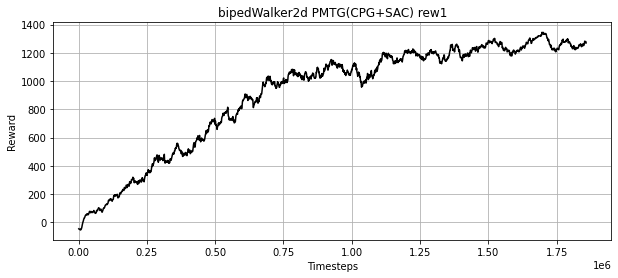

In [17]:
fig = plt.figure(figsize=(10, 4), facecolor="white")
plt.grid()
plt.plot(callback.s_timestep, callback.s_reward, 'k')
plt.xlabel("Timesteps")
plt.ylabel("Reward")
plt.title("bipedWalker2d PMTG(CPG+SAC) rew1")

Close environments

In [21]:
env.close()
eval_env.close()